train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

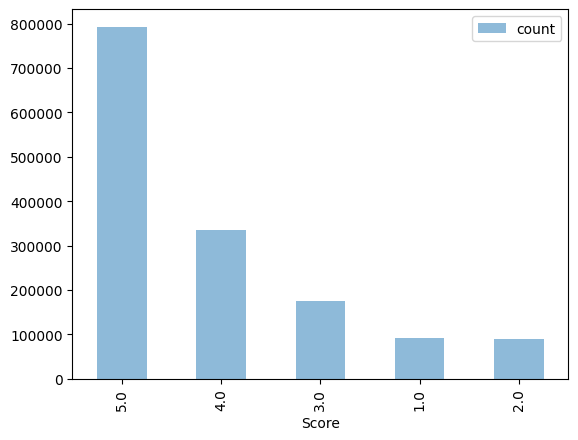


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START
Best parameters from GridSearchCV:  {'C': 0.05, 'loss': 'squared_hinge'}
Accuracy on testing set =  0.6505991652080247
              precision    recall  f1-score   support

         1.0       0.52      0.67      0.59       912
         2.0       0.34      0.42      0.38       897
         3.0       0.45      0.37      0.41      1761
         4.0       0.50      0.43      0.46      3352
         5.0       0.80      0.83      0.81      7932

    accuracy                           0.65     14854
   macro avg       0.52      0.55      0.53     14854
weighted avg       0.65      0.65      0.65     14854



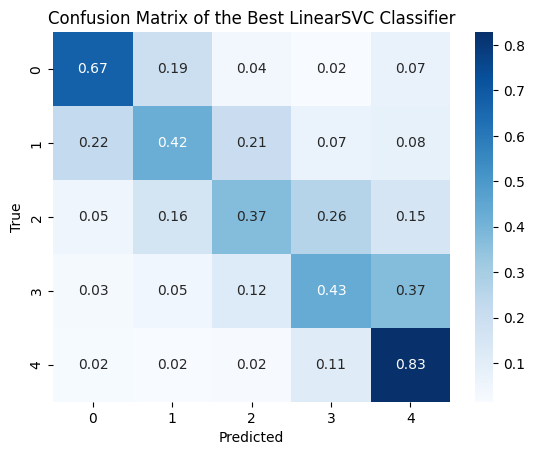

In [1]:
# Libraries
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Loading the Files

# Download the csv files into the data/ directory.

trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features
def add_features_to(df):
    # Feature extraction
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Convert Time to datetime
    df['ReviewTime'] = pd.to_datetime(df['Time'], unit='s')
    df['Year'] = df['ReviewTime'].dt.year
    df['Month'] = df['ReviewTime'].dt.month
    df['DayOfWeek'] = df['ReviewTime'].dt.dayofweek

    # Text length features
    df['Summary_length'] = df['Summary'].fillna('').apply(len)
    df['Text_length'] = df['Text'].fillna('').apply(len)

    return df

if exists('X_train.csv') and exists('X_submission.csv'):
    X_train = pd.read_csv("X_train.csv")
    X_submission = pd.read_csv("X_submission.csv")
else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train = train[train['Score'].notnull()]

    X_submission.to_csv("X_submission.csv", index=False)
    X_train.to_csv("X_train.csv", index=False)

# Sample + Split into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train,
    X_train['Score'],
    test_size= 0.01,
    random_state=3,
    stratify=X_train['Score']
)


# Compute user average score and standard deviation
user_stats = X_train.groupby('UserId')['Score'].agg(['mean', 'std']).reset_index()
user_stats = user_stats.rename(columns={'mean': 'User_avg_score', 'std': 'User_std_score'})

product_stats = X_train.groupby('ProductId')['Score'].agg(['mean', 'std']).reset_index()
product_stats = product_stats.rename(columns={'mean': 'Product_avg_score', 'std': 'Product_std_score'})

# Compute UserId and ProductId mode and proportion
def compute_mode_proportion(df, group_col, target_col):
    mode_df = df.groupby(group_col)[target_col].agg(
        lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]).reset_index()
    mode_df = mode_df.rename(columns={target_col: f'{group_col}_mode_score'})

    proportion_df = df.groupby(group_col)[target_col].apply(lambda x: x.value_counts().iloc[0] / len(x)).reset_index()
    proportion_df = proportion_df.rename(columns={target_col: f'{group_col}_mode_proportion'})

    return pd.merge(mode_df, proportion_df, on=group_col)

user_mode_proportion = compute_mode_proportion(X_train, 'UserId', 'Score')
product_mode_proportion = compute_mode_proportion(X_train, 'ProductId', 'Score')

# Convert to dictionaries for mapping
user_mode_dict = user_mode_proportion.set_index('UserId').to_dict(orient='index')
product_mode_dict = product_mode_proportion.set_index('ProductId').to_dict(orient='index')

# Now drop 'Score' from X_train, since we have Y_train
X_train = X_train.drop(columns=['Score'])
X_test = X_test.drop(columns=['Score'])
# Feature Selection
features = [
    'HelpfulnessNumerator',
    'HelpfulnessDenominator',
    'Time',
    'Helpfulness',
    'Year',
    'Month',
    'DayOfWeek',
    'Summary_length',
    'Text_length',
    'UserId',
    'ProductId'
]

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Merge user stats
X_train_select = pd.merge(X_train_select, user_stats, on='UserId', how='left')
X_test_select = pd.merge(X_test_select, user_stats, on='UserId', how='left')
X_submission_select = pd.merge(X_submission_select, user_stats, on='UserId', how='left')

# Merge product stats
X_train_select = pd.merge(X_train_select, product_stats, on='ProductId', how='left')
X_test_select = pd.merge(X_test_select, product_stats, on='ProductId', how='left')
X_submission_select = pd.merge(X_submission_select, product_stats, on='ProductId', how='left')

# Handle missing values
global_mean_score = Y_train.mean()

for df in [X_train_select, X_test_select, X_submission_select]:
    df['User_avg_score'] = df['User_avg_score'].fillna(global_mean_score)
    df['User_std_score'] = df['User_std_score'].fillna(0)
    df['Product_avg_score'] = df['Product_avg_score'].fillna(global_mean_score)
    df['Product_std_score'] = df['Product_std_score'].fillna(0)

def merge_mode_features(df, group_col, mode_dict):
    df[f'{group_col}_mode_score'] = df[group_col].map(
        lambda x: mode_dict[x][f'{group_col}_mode_score'] if x in mode_dict else global_mean_score)
    df[f'{group_col}_mode_proportion'] = df[group_col].map(
        lambda x: mode_dict[x][f'{group_col}_mode_proportion'] if x in mode_dict else 0)
    return df

X_train_select = merge_mode_features(X_train_select, 'UserId', user_mode_dict)
X_test_select = merge_mode_features(X_test_select, 'UserId', user_mode_dict)
X_submission_select = merge_mode_features(X_submission_select, 'UserId', user_mode_dict)

X_train_select = merge_mode_features(X_train_select, 'ProductId', product_mode_dict)
X_test_select = merge_mode_features(X_test_select, 'ProductId', product_mode_dict)
X_submission_select = merge_mode_features(X_submission_select, 'ProductId', product_mode_dict)

features = [
    'HelpfulnessNumerator',
    'HelpfulnessDenominator',
    'Time',
    'Helpfulness',
    'Year',
    'Month',
    'DayOfWeek',
    'Summary_length',
    'Text_length',
    'User_avg_score',
    'User_std_score',
    'Product_avg_score',
    'Product_std_score',
    'UserId_mode_score',
    'UserId_mode_proportion',
    'ProductId_mode_score',
    'ProductId_mode_proportion'
]


X_train_select = X_train_select[features]
X_test_select = X_test_select[features]
X_submission_select = X_submission_select[features]


tfidf_summary = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_text = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit and transform the text data
tfidf_summary.fit(X_train['Summary'].fillna(''))
tfidf_text.fit(X_train['Text'].fillna(''))

summary_train_tfidf = tfidf_summary.transform(X_train['Summary'].fillna(''))
text_train_tfidf = tfidf_text.transform(X_train['Text'].fillna(''))

summary_test_tfidf = tfidf_summary.transform(X_test['Summary'].fillna(''))
text_test_tfidf = tfidf_text.transform(X_test['Text'].fillna(''))

summary_submission_tfidf = tfidf_summary.transform(X_submission['Summary'].fillna(''))
text_submission_tfidf = tfidf_text.transform(X_submission['Text'].fillna(''))


from scipy.sparse import hstack

X_train_final = hstack([X_train_select, summary_train_tfidf, text_train_tfidf])
X_test_final = hstack([X_test_select, summary_test_tfidf, text_test_tfidf])
X_submission_final = hstack([X_submission_select, summary_submission_tfidf, text_submission_tfidf])

# Scaling
scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse matrices
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)
X_submission_scaled = scaler.transform(X_submission_final)

# Model Creation

sample_size = 100000
X_train_sample, _, Y_train_sample, _ = train_test_split(
    X_train_scaled,
    Y_train,
    train_size=sample_size,
    random_state=0,
    stratify=Y_train
)

param_grid = {
    'C': [0.02,0.04,0.05,0.06,0.08,0.1,1],
    'loss': ['squared_hinge'],
}

svc = LinearSVC(random_state=0, max_iter=10000, dual=False, class_weight='balanced')

grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_sample, Y_train_sample)

print("Best parameters from GridSearchCV: ", grid_search.best_params_)

best_svc = grid_search.best_estimator_
best_svc.fit(X_train_scaled, Y_train)

# Predict the score using the model
Y_test_predictions = best_svc.predict(X_test_scaled)

# Model Evaluation
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print(classification_report(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
plt.title('Confusion Matrix of the Best LinearSVC Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file
# Create the submission file
X_submission['Score'] = best_svc.predict(X_submission_scaled)
submission = X_submission[['Id', 'Score']]
submission.to_csv("submission.csv", index=False)


